This notebook ingests the `My Clippings scribe.txt` file from the Kindle Scribe (located in the '/Documents' folder on your Kindle). You need to manually copy the file from your Kindle by connecting it to your PC and then uploading it to the Colab directory.  The result is a more useful database with:

+ `source` (the book, pdf or other source)

+ `reference` (details of the reference: page, location, date of clipping)

+ `quote` (the actual text clipped on the Kindle--for the Scribe it can span more than 1 line and thus required re-writing the original for the Paperwhite!)

columns that can be easily explored. You can, for example, display all quotes from a `source` or search `quote` for particular search terms, including using 'A or B' or 'A and B' search logic. Very basic machine learning is used to summarise topics found in the clippings.

The second part of the notebook automatically generates vocabulary words from single word quotes (when you highlight only one word in your Kindle). This permits an automatic collection of new vocabulary words (and, optionally, combination with an existing list of vocabulary words). A separate notebook, `oxford dictionary lookup.ipynb` automatically looks up the definition of words using the Oxford dictionary API (which you will need to register for and obtain). While the API is free, there are limits to the number of words that can be looked up.

You will need the following files in the base directory:
- `My Clippings scribe.txt`
- current vocabulary words in a csv file (you can import old vocabulary words here using a spreadsheet for example)
- `blank.csv` if a vocabulary file is not available

The vocabulary portion will save the new vocabulary words to `Kindle_scribe_vocab.csv`. It will then load up previously saved vocabulary words found in `Kindle_scribe_vocab_updated.csv`. If this Jupyter notebook has not been run before, the `Kindle_scribe_vocab_updated.csv` file will not exist and the notebook will look for a base vocabulary file (`2DoList.csv`) failing which it will load up a blank.csv file. If you wish to add your existing vocabulary words with definitions, save them to a csv file format using a spreadsheet and save them as `2DoList.csv` (or modify the base vocabulary file name accordingly in the notebook).

This notebook has been tested to run in Colab. If you want to run it locally, you will need to install any dependencies not in your environment.

This is version 2, updated to handle the multi-line quotes in the Kindle Scribe. (py310 conda env)

In [5]:
# changed import to use pandas then polars as there seems to be a 2,225 line
# limit in polars importing; pandas imports over 10,000 lines

import pandas as pd
import polars as pl
import cupy as np
colspecs = [(None, None)]
kindle_clipping_file="My Clippings scribe.txt"

# Read the fixed-width file with pandas
# using polars.read_csv() stops reading after 2,225 rows???
# need to pd.read_fwf then convert to polars to ensure at 10,000 rows read in
datapd = pd.read_fwf(kindle_clipping_file, colspecs=colspecs, header=None)

# Convert the pandas DataFrame to a Polars DataFrame
data = pl.from_pandas(datapd)
# must rename pandas column 0 to column_1 for the next section below
data = data.rename({"0": "column_1"})
#data = pl.read_csv(kindle_clipping_file, columns=[0], has_header=False)
with pl.Config(fmt_str_lengths=300, tbl_rows=20):
    display(data)

column_1
str
"""As Twitter destroys its brand by renaming itself X, Mastodon user numbers are again soaring _ TechCrunch (techcrunch.com)"""
"""- Your Highlight on Location 12-12 | Added on Thursday, August 17, 2023 12:13:47 PM"""
"""reached 2.1 million"""
"""=========="""
"""These Are the Plunderers: How Private Equity Runs—and Wrecks—America: How Private Equity Runs—and Wrecks—America (Gretchen Morgenson;Joshua Rosner)"""
"""- Your Highlight on page 142 | Location 2164-2166 | Added on Thursday, August 17, 2023 1:27:30 PM"""
"""The GNC trade generated more than 100 percent profit to Apollo. Then the retailer issued shares to the public in 2011, allowing Ares to exit. GNC’s operations declined and it filed for bankruptcy in 2020."""
"""=========="""
"""These Are the Plunderers: How Private Equity Runs—and Wrecks—America: How Private Equity Runs—and Wrecks—America (Gretchen Morgenson;Joshua Rosner)"""


In [6]:
# ai suggestion modified:

def categorize_dataframe(df):

    # Initialize empty df to store the values
    source = pl.DataFrame({
        'source': [""]
    })

    reference = pl.DataFrame({
        'reference': [""]
    })

    quote = pl.DataFrame({
        'quote': ['']
    })


    # Initialize a counter
    counter = 0
    quote_count = 0
    holder = ""


    # go through dataframe to extract source, reference and quote
    for value in data['column_1']:

        # deal with empty quote line
        if counter == 2: 
            if value == '==========':

                new_row = pl.DataFrame({
                    'quote': [""]
                })
                quote = quote.vstack(new_row)


        #######################################################
        # normal operations:

        if counter == 0:
            new_row = pl.DataFrame({
                'source': [value]
            })
            new_row = new_row.with_columns(new_row["source"].cast(pl.datatypes.Utf8))
            source = source.vstack(new_row)
            counter += 1
            
        elif counter == 1:
            new_row = pl.DataFrame({
                'reference': [value]
            })
            new_row = new_row.with_columns(new_row["reference"].cast(pl.datatypes.Utf8))
            reference = reference.vstack(new_row)
            counter += 1
            
        else:
            # for quote, need to handle multi line quotes, combine them to one line
            # otherwise they cannot be joined with other columns

            if not (value == '=========='):
                quote_count +=1
                # combine strings to holder
                # needed str(holder) + str(value) instead of holder + str
                # because rapids threw up error about empty str
                # but no error on py310 conda env!
                holder = str(holder) + str(value)
                # print(holder, quote_count)
                list_holder = holder[:]
                new_row = pl.DataFrame({
                    'quote': [list_holder]
                })
                new_row = new_row.with_columns(new_row["quote"].cast(pl.datatypes.Utf8))

                # update quote normally if quote_count is not > 1:
                if quote_count == 1:
                    quote = quote.vstack(new_row)

                # if multiline and quote_count > 1: slice off last row before updating
                elif quote_count > 1:
                    # print(list_holder, quote_count)
                    # update previous row to avoid duplication
                    quote = quote[:-1]
                    quote = quote.vstack(new_row)
                
                counter += 1
                
                    
            else:   # hit delimiter '==========='
                quote_count = 0
                #counter += 1

        ################################################
        if value == '==========':
            counter = 0
            holder = ""
            continue
    

    # combine source, reference, quote into new_df
    new_df = source[1:].hstack(reference[1:])
    new_df = new_df.hstack(quote[1:])
    return new_df


new_df = categorize_dataframe(data)


In [7]:
with pl.Config(fmt_str_lengths=500, tbl_rows=30):
    display(new_df)

source,reference,quote
str,str,str
"""As Twitter destroys its brand by renaming itself X, Mastodon user numbers are again soaring _ TechCrunch (techcrunch.com)""","""- Your Highlight on Location 12-12 | Added on Thursday, August 17, 2023 12:13:47 PM""","""reached 2.1 million"""
"""These Are the Plunderers: How Private Equity Runs—and Wrecks—America: How Private Equity Runs—and Wrecks—America (Gretchen Morgenson;Joshua Rosner)""","""- Your Highlight on page 142 | Location 2164-2166 | Added on Thursday, August 17, 2023 1:27:30 PM""","""The GNC trade generated more than 100 percent profit to Apollo. Then the retailer issued shares to the public in 2011, allowing Ares to exit. GNC’s operations declined and it filed for bankruptcy in 2020."""
"""These Are the Plunderers: How Private Equity Runs—and Wrecks—America: How Private Equity Runs—and Wrecks—America (Gretchen Morgenson;Joshua Rosner)""","""- Your Highlight on page 142 | Location 2175-2176 | Added on Thursday, August 17, 2023 1:28:06 PM""","""Boom times ended with a hard stop in 2008, when the real estate mania collapsed and investors began to understand how pernicious the banks’ mortgage misdeeds had been. After peaking in October 2007, the stock market was trending down."""
"""These Are the Plunderers: How Private Equity Runs—and Wrecks—America: How Private Equity Runs—and Wrecks—America (Gretchen Morgenson;Joshua Rosner)""","""- Your Highlight on page 227 | Location 3475-3478 | Added on Thursday, August 17, 2023 1:35:12 PM""","""Another former worker at the facility reported that management repeatedly put off repairs to keep costs low, including failing to repair a roof leak properly for five years. “A lot of times we’d have to close the dining room because we were afraid the Sheetrock would fall on somebody,” he said. “For a couple of years, it had a tarp over that section. It seemed like if you’re going run that type of business, you have to have a dry place for your residents.”"""
"""These Are the Plunderers: How Private Equity Runs—and Wrecks—America: How Private Equity Runs—and Wrecks—America (Gretchen Morgenson;Joshua Rosner)""","""- Your Highlight on page 228 | Location 3486-3488 | Added on Thursday, August 17, 2023 1:35:56 PM""","""“It’s a horrific thing to ask the family member to do,” Chicotel said. But restraining orders are common in nursing homes, especially when family members point out deficiencies in care, he added. “When visitors are concerned about care their loved one is getting, staff or management will see the resident is targeted as challenging,”"""
"""These Are the Plunderers: How Private Equity Runs—and Wrecks—America: How Private Equity Runs—and Wrecks—America (Gretchen Morgenson;Joshua Rosner)""","""- Your Highlight on page 231 | Location 3529-3531 | Added on Thursday, August 17, 2023 1:38:29 PM""","""“Even when you say something is unsafe there’s little change that comes out of it,” Sprague said of her privateer managers. “If there’s a profit in it, then they’ll do it. They’re not going to do a single thing that doesn’t benefit them, first and foremost.”"""
"""These Are the Plunderers: How Private Equity Runs—and Wrecks—America: How Private Equity Runs—and Wrecks—America (Gretchen Morgenson;Joshua Rosner)""","""- Your Highlight on page 232 | Location 3543-3544 | Added on Thursday, August 17, 2023 1:39:26 PM""","""Once the privateers recognized that the Federal Reserve Board stood ready to bail them out of bad trades, they returned to the trough. With a vengeance."""
"""China’s property crash is becoming more dangerous by the day (www.telegraph.co.uk)""","""- Your Highlight on Location 13-14 | Added on Thursday, August 17, 2023 2:29:15 PM""","""Cai Fang, a rate-setter at the central bank, has called for a $550bn blast of helicopter money – or high-powered QE injected into the veins of the economy – in order to stop a deflationary psychology taking hold as frightened households retrench."""
"""China’s property crash is becoming more dangerous by th

In [8]:
# source is [:,0], reference is [:,1], quote is [:,2]
with pl.Config(fmt_str_lengths=500):
    display(new_df[:,0])

source
str
"""As Twitter destroys its brand by renaming itself X, Mastodon user numbers are again soaring _ TechCrunch (techcrunch.com)"""
"""These Are the Plunderers: How Private Equity Runs—and Wrecks—America: How Private Equity Runs—and Wrecks—America (Gretchen Morgenson;Joshua Rosner)"""
"""These Are the Plunderers: How Private Equity Runs—and Wrecks—America: How Private Equity Runs—and Wrecks—America (Gretchen Morgenson;Joshua Rosner)"""
"""These Are the Plunderers: How Private Equity Runs—and Wrecks—America: How Private Equity Runs—and Wrecks—America (Gretchen Morgenson;Joshua Rosner)"""
"""These Are the Plunderers: How Private Equity Runs—and Wrecks—America: How Private Equity Runs—and Wrecks—America (Gretchen Morgenson;Joshua Rosner)"""
"""These Are the Plunderers: How Private Equity Runs—and Wrecks—America: How Private Equity Runs—and Wrecks—America (Gretchen Morgenson;Joshua Rosner)"""
"""These Are the Plunderers: How Private Equity Runs—and Wrecks—America: How Private Equity Runs—and Wrecks—America (Gretchen Morgenson;Joshua Rosner)"""
"""China’s property crash is becoming more dangerous by the day (www.telegraph.co.uk)"""
"""China’s property crash is becoming more dangerous by the day (www.telegraph.co.uk)"""


In [9]:
# test: for a specific quote, print source, highlight detail and quote
# repeat until last

quote_number=480
while quote_number < new_df.shape[0]:
      print(new_df[quote_number, 0] + '\n',   
      new_df[quote_number, 1] + '\n',
      new_df[quote_number,2] + '\n')

      quote_number += 1


Speed, Python_ Pick Two. How CUDA Graphs Enable Fast Python Code for Deep Learning _ by Fireworks.ai _ Aug, 2023 _ Medium (blog.fireworks.ai)
 - Your Highlight on Location 147-148 | Added on Wednesday, August 30, 2023 5:18:07 PM
 We find that without CUDA graphs, LLaMA-7B inference executes at 30 tokens/sec, but with CUDA graphs enabled it executes at 69 tokens/sec for a 2.3x speedup.

When the generative AI hype fades (Matt Asay)
 - Your Highlight on Location 16-19 | Added on Wednesday, August 30, 2023 7:27:36 PM
 Once all the hype around GenAI fades—and it will—we’ll be left with increased investments in deep learning and machine learning, which may be GenAI’s biggest contribution to AI.

When the generative AI hype fades (Matt Asay)
 - Your Highlight on Location 36-38 | Added on Wednesday, August 30, 2023 7:28:35 PM
 “Small, fast, and cheap-to-run reinforcement learning models handily beat massive hundred-billion-parameter LLMs at all kinds of tasks, from playing games to writing co

In [10]:
# output all the unique sources used in Kindle clippings
with pl.Config(fmt_str_lengths=200):
    display(new_df[:,0].unique())

source
str
"""The Intelligent Investor, Rev. Ed"""
"""the-economist 13-01-2024 (Nook) (NewspaperDirect)"""
"""Numba, Mojo, and Compilers for Numerical Computing (Stan Seibert)"""
"""barrons 15-01-2024 (Nook) (NewspaperDirect)"""
"""Gmail - Hitchhiker's Guide to the Equity Risk Premium (Unknown)"""
"""the-wall-street-journal 08-09-2023 (Sony) (NewspaperDirect)"""
"""the-wall-street-journal 23-08-2023 (Sony) (NewspaperDirect)"""
"""Bloomberg Evening Briefing_ Another Bad Sign for China’s Economy - Bloomberg (www.bloomberg.com)"""
"""What Evergrande’s Collapse Might Mean for Global Business (More about Ephrat Livni)"""


In [11]:
# save new_df to file for machine learning by other notebooks
# use 'kindle_scribe_new_df.csv' in a separate notebook for machine learning text processing
new_df.write_csv('kindle_scribe_new_df.csv')

# Set search parameters here

With this Kindle clipping database, you can now define `search_term` and `search_term2`. For example, if you only want to search within Shakespeare books, you can enter 'shakespeare' as `search_term`. Leaving a search term blank searches all instances or sources. You can also be very specific, such as `'tesla | China'` to search for 'tesla' or 'China' in the clipping. If you want both, use `'tesla .* China'`.

In [12]:
# leave blank to search all sources
# syntax for more than 1 search term?
# (?i) is case insensitive

source_search_term = ('(?i)')
quote_search_term = ('(?i)property')

df_search = new_df.filter(pl.col('source').str.contains(source_search_term))
df_search = df_search.filter(pl.col('quote').str.contains(quote_search_term))

with pl.Config(fmt_str_lengths=500):
    display(df_search[['source','reference','quote']])

source,reference,quote
str,str,str
"""China’s property crash is becoming more dangerous by the day (www.telegraph.co.uk)""","""- Your Highlight on Location 38-41 | Added on Thursday, August 17, 2023 2:32:48 PM""","""China’s $60 trillion property edifice is by far the largest asset class in the world. It accounts for half of the world’s entire property sales, an astonishing figure given that China’s workforce is already contracting and net migration from the countryside has stopped."""
"""China’s property crash is becoming more dangerous by the day (www.telegraph.co.uk)""","""- Your Highlight on Location 41-42 | Added on Thursday, August 17, 2023 2:33:36 PM""","""The developers have debts of $5 trillion. By comparison, this is six times greater than America’s $800bn subprime property debt on the eve of the Lehman crisis."""
"""China’s property crash is becoming more dangerous by the day (www.telegraph.co.uk)""","""- Your Highlight on Location 45-46 | Added on Thursday, August 17, 2023 2:34:17 PM""","""They rely on property for 38pc of total revenue, mostly from land sales. These sales have collapsed. The finance ministry says local government income fell 21pc in the first half of 2023."""
"""The Economist (calibre)""","""- Your Highlight on page 47 | Location 715-718 | Added on Friday, August 18, 2023 2:19:41 PM""","""But the government’s moves have mostly backfired. The public humiliation of tech entrepreneurs was a punch in the stomach for ambitious youngsters inspired by their example (though young leftists have celebrated the party’s humbling of billionaires). And the regulatory crackdowns on their companies, as well as on property developers, have hobbled some of the most reliable employers of China’s university-educated youth."""
"""The Economist (calibre)""","""- Your Highlight on page 185 | Location 2831-2835 | Added on Friday, August 18, 2023 5:15:59 PM""","""The calculation has changed in recent days. Country Garden’s issue is not one of over-leverage in the style of Evergrande. Instead, it is a victim of a loss of confidence among regular folk—a sign the government is losing control. After a short rebound following the lifting of covid-19 controls, the property crisis has intensified. Prices are dropping. Sales among the 100 biggest developers fell by 33% in July compared with a year earlier. Country Garden’s tumbled by 60%. The firm’s decline is …"
"""China Faces a Crisis in Its Real Estate Sector - The New York Times (www.nytimes.com)""","""- Your Highlight on Location 40-43 | Added on Sunday, August 20, 2023 4:54:33 PM""","""One after another, the companies began to crumble as they could not pay their bills. More than 50 Chinese property developers have defaulted or failed to make debt payments in the last three years, according to credit ratings agency Standard & Poor’s. The defaults have exposed a reality of China’s property boom: the borrow-to-build model works only as long as prices keep going up."""
"""China’s Property Crisis Is Rippling Through the Economy - The New York Times (www.nytimes.com)""","""- Your Highlight on Location 23-23 | Added on Wednesday, August 30, 2023 11:25:58 AM""","""Small businesses and workers who thrived on the decades-long property boom are no longer getting paid."""
"""the-economist 26-08-2023 (Sony) (NewspaperDirect)""","""- Your Highlight on Location 4363-4367 | Added on Wednesday, August 30, 2023 9:02:24 PM""","""But what if things go badly wrong in China? Under a worst-case scenario, a property meltdown could reverberate through the world’s financial markets. A study published by the Bank of England in 2018 found that a “hard landing” in China, where economic growth fell from 7% to -1%, would cause global asset prices to fall and rich-world currencies to rise as investors rushed in the direction of safer assets. Overall, British gdp would drop by 1.2%. Although most Western financial institutions have …"
"""the-wall-street-journal 07-09-2023 (Sony) (NewspaperDirect)""","""- Yo

In [13]:
# used a dataset visualisation example code to display the length of the highlight column

"""Module to explore data.
Contains functions to help study, visualize and understand datasets.
https://github.com/google/eng-edu/blob/main/ml/guides/text_classification/explore_data.py
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer


def get_num_classes(labels):
    """Gets the total number of classes.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    # Returns
        int, total number of classes.
    # Raises
        ValueError: if any label value in the range(0, num_classes - 1)
            is missing or if number of classes is <= 1.
    """
    num_classes = max(labels) + 1
    missing_classes = [i for i in range(num_classes) if i not in labels]
    if len(missing_classes):
        raise ValueError('Missing samples with label value(s) '
                         '{missing_classes}. Please make sure you have '
                         'at least one sample for every label value '
                         'in the range(0, {max_class})'.format(
                            missing_classes=missing_classes,
                            max_class=num_classes - 1))

    if num_classes <= 1:
        raise ValueError('Invalid number of labels: {num_classes}.'
                         'Please make sure there are at least two classes '
                         'of samples'.format(num_classes=num_classes))
    return num_classes


def get_num_words_per_sample(sample_texts):
    """Gets the median number of words per sample given corpus.
    # Arguments
        sample_texts: list, sample texts.
    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)


def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 2),
                                          num_ngrams=50):
    """Plots the frequency distribution of n-grams.
    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()


def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.
    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()


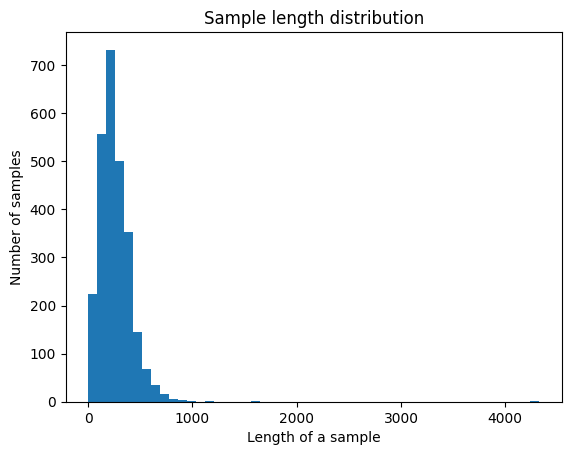

In [14]:
df = new_df.to_pandas()
plot_sample_length_distribution(df['quote'])

# Topic generator
Simple code sample from Bing AI to get an overview of the topics covered in the Kindle clippings.

In [15]:
# modified sample code from Bing AI to get some overview of the topics
# covered in the Kindle clipping dataset; once you have topics, you can
# conduct boolean searches as shown previously for more detail

# Import the necessary modules
# from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Extract the document-term matrix using CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                             max_features=1000,
                             stop_words='english')
X = vectorizer.fit_transform(df['quote'])

# Fit the LDA model with n_components topics
lda = LatentDirichletAllocation(n_components=10, max_iter=10,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(X)

# Print the top 10 words for each topic
# feature_names = vectorizer.get_feature_names() bug requires _out() until updated
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-11:-1]]))
    print()

Topic #0:
debt billion investors million real companies market money financial banks

Topic #1:
long term memory small short performance mental large businesses developed

Topic #2:
practice news spent bad place deliberate book generally good target

Topic #3:
china chinese tesla musk said country electric company vehicles ev

Topic #4:
year market quarter rates china growth cent price according higher

Topic #5:
ai just people researchers need new learning google research work

Topic #6:
said ai 000 company new world technology year time people

Topic #7:
state group said data intel new hydrogen government power company

Topic #8:
said mr trump workers did law german employees little business

Topic #9:
companies tech important products able latest food data rule big



# Vocabulary generator

Another potentially useful feature is generating vocabulary automatically from the Kindle clippings. The code takes all single word clippings and adds them to the 'Kindle_vocab.csv' file.

In [16]:
vocabulary = df['quote'].str.strip().str.split(' ').str.len().eq(1)
output = df[vocabulary]
vocab = output.loc[:,('quote')].str.rstrip('.,;?')
df_csv = vocab.to_csv('Kindle_scribe_vocab.csv', index=True)
print('Printed to Kindle_scribe_vocab.csv')

Printed to Kindle_scribe_vocab.csv


In [17]:
print(vocab)

31                                                   Scam
51                                                 fervid
189                                                  Good
240                                                      
241                                                      
268                                             Pointless
299                                               .split(
478                                   torch.cuda.Stream()
500                                             Aegyptius
882                                                      
1056                                        hyperpathetic
1057                                         appositions—
1064                                            parataxes
1065                                       hypotactically
1097                                              piscine
1164                                         glass-gazing
1166                                        barber-monger
1265          

In [18]:
# loads updated vocabulary file first. If this is the first time because Kindle clips have not been added
# or the file is missing then load base vocabulary file from 2DoList.csv
# if that file is missing, load blank.csv
# using pandas instead of polars

try:
    main_vocabulary = pl.read_csv("Kindle_scribe_vocab_updated.csv")
except Exception as e:
    print("Kindle_scribe_vocab_updated.csv file not found, loading base file.")
    try:
        main_vocabulary = pl.read_csv("2DoList.csv")     # csv vocabulary file created previously
    except Exception as e:
        main_vocabulary = pl.read_csv("blank.csv")       # empty csv file if no vocabulary files available
main_vocabulary.shape

(1144, 2)

In [19]:
main_vocabulary

WORD,NOTE
str,str
"""abaddon""",null
"""abaft""",null
"""abba""",null
"""aberglaube""",null
"""abet""",null
"""abeyance""",null
"""abidden""",null
"""abigail""",null
"""abiogenesis""",null


In [20]:
# make sure index is the same
# polars has trouble here, using pandas for now
vocab = pl.Series(vocab)
vocab.index = np.arange(0, len(vocab) + 0)

# object to dataframe
vocab_add = pl.DataFrame(vocab)

# create same column name
vocab_add.columns = ['WORD'] 

In [21]:
# filter for empty entries:
#vocab_add = pl.Series(vocab_add)
#vocab_add.set(vocab_add.str.lengths() == 0, None)
#vocab_add = vocab_add.drop_nulls()
vocab_add = vocab_add.filter(pl.col('WORD') != "")
vocab_add

WORD
str
"""Scam"""
"""fervid"""
"""Good"""
"""Pointless"""
""".split("""
"""torch.cuda.Str…"
"""Aegyptius"""
"""hyperpathetic"""
"""appositions—"""


In [22]:
# filter null entries where WORD is null
main_vocabulary = main_vocabulary.filter(pl.col('WORD').is_not_null())
main_vocabulary

WORD,NOTE
str,str
"""abaddon""",null
"""abaft""",null
"""abba""",null
"""aberglaube""",null
"""abet""",null
"""abeyance""",null
"""abidden""",null
"""abigail""",null
"""abiogenesis""",null


In [23]:

# to vstack, need same column number in two dataframes

vocab_add = vocab_add.with_columns([
    pl.lit(None).alias(' NOTE').cast(pl.datatypes.Utf8),
])
new_vocabulary = main_vocabulary.vstack(vocab_add)
new_vocabulary
# save to csv
#df_csv = main_vocabulary.to_csv('Kindle_scribe_vocab_updated.csv', index=False)                # index=False as otherwise adding extra index columns
new_vocabulary.write_csv('Kindle_scribe_vocab_updated.csv')
print('Saved new Kindle clipping words to Kindle_scribe_vocab_updated.csv.')

Saved new Kindle clipping words to Kindle_scribe_vocab_updated.csv.


In [24]:
# update with new words only in pandas
# https://stackoverflow.com/questions/52342627/appending-only-new-values-from-a-dataframe-to-another-dataframe-in-pandas

'''
updated_vocabulary = vocab_add.merge(main_vocabulary, how='left', indicator=True)

# selecting rows that are flagged with left_only
updated_vocabulary = updated_vocabulary[updated_vocabulary._merge == 'left_only'].iloc[:,:-1]

# update main_vocabulary with only updated words
main_vocabulary = pl.concat([main_vocabulary, updated_vocabulary], ignore_index=True)

display(main_vocabulary.shape)     #  checked that it does not add duplicate rows or columns even when repeated

# save to csv
df_csv = main_vocabulary.to_csv('Kindle_scribe_vocab_updated.csv', index=False)                # index=False as otherwise adding extra index columns
print('Saved new Kindle clipping words to Kindle_scribe_vocab_updated.csv.')
'''

"\nupdated_vocabulary = vocab_add.merge(main_vocabulary, how='left', indicator=True)\n\n# selecting rows that are flagged with left_only\nupdated_vocabulary = updated_vocabulary[updated_vocabulary._merge == 'left_only'].iloc[:,:-1]\n\n# update main_vocabulary with only updated words\nmain_vocabulary = pl.concat([main_vocabulary, updated_vocabulary], ignore_index=True)\n\ndisplay(main_vocabulary.shape)     #  checked that it does not add duplicate rows or columns even when repeated\n\n# save to csv\ndf_csv = main_vocabulary.to_csv('Kindle_scribe_vocab_updated.csv', index=False)                # index=False as otherwise adding extra index columns\nprint('Saved new Kindle clipping words to Kindle_scribe_vocab_updated.csv.')\n"

In [25]:
test_vocabulary = pl.read_csv("Kindle_scribe_vocab_updated.csv")
test_vocabulary.shape
test_vocabulary

WORD,NOTE
str,str
"""abaddon""",null
"""abaft""",null
"""abba""",null
"""aberglaube""",null
"""abet""",null
"""abeyance""",null
"""abidden""",null
"""abigail""",null
"""abiogenesis""",null
